In [1]:
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # data visualization
import matplotlib.dates as mdates
import warnings
from dateutil.relativedelta import relativedelta
from functions import *

warnings.filterwarnings(action='ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
# Any results you write to the current directory are saved as output.
coinbase = pd.read_csv(
    "./data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")

print(list(coinbase.columns), "\nSHAPE ::", coinbase.shape)
for i in coinbase.columns:
    print(i, "::", coinbase[i].dtype)


coinbase.describe()


['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price'] 
SHAPE :: (4857377, 8)
Timestamp :: int64
Open :: float64
High :: float64
Low :: float64
Close :: float64
Volume_(BTC) :: float64
Volume_(Currency) :: float64
Weighted_Price :: float64


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.857377e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06
mean,1.471301e+09,6.009024e+03,6.013357e+03,6.004488e+03,6.009014e+03,9.323249e+00,4.176284e+04,6.008935e+03
std,8.428019e+07,8.996247e+03,9.003521e+03,8.988778e+03,8.996360e+03,3.054989e+01,1.518248e+05,8.995992e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.398179e+09,4.438600e+02,4.440000e+02,4.435200e+02,4.438600e+02,4.097759e-01,4.521422e+02,4.438306e+02
50%,1.471428e+09,3.596970e+03,3.598190e+03,3.595620e+03,3.597000e+03,1.979811e+00,3.810124e+03,3.596804e+03
75%,1.544288e+09,8.627270e+03,8.632980e+03,8.621090e+03,8.627160e+03,7.278216e+00,2.569821e+04,8.627637e+03
max,1.617149e+09,6.176356e+04,6.178183e+04,6.167355e+04,6.178180e+04,5.853852e+03,1.390067e+07,6.171621e+04


In [3]:
filtered = filterByInterval(coinbase, relativedelta(months=3))

if hasMissingData(filtered['Timestamp'].values):
    raise Exception("Missing data in the dataframe")

print("O intervalo entre datas é de {} até {}, somando um total de {} registros.".format(
    getFirstTimestamp(filtered), getLastTimestamp(filtered), filtered.shape[0]))


O intervalo entre datas é de 31/12/2020 00:00:00 até 31/03/2021 00:00:00, somando um total de 129601 registros.


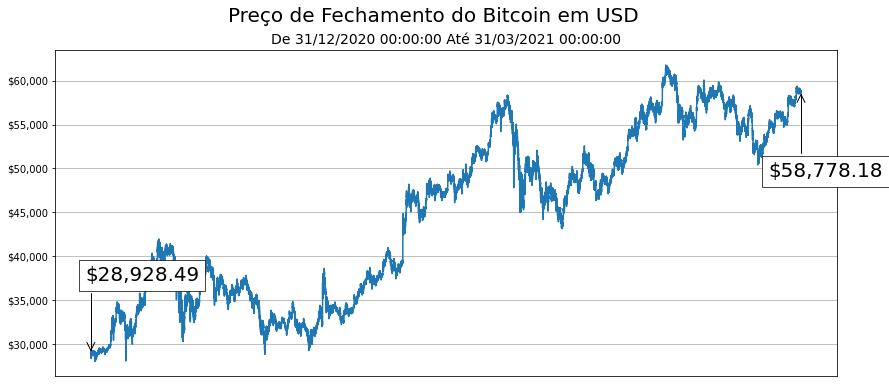

In [4]:
kw = dict(annot_yaxis=10000, annot_xaxis=-1000, annot_xaxis_pos=-6000, annot_yaxis_pos=-
          8000, angle="angle,angleA=0,angleB=90", angle_pos="angle,angleA=0,angleB=-90")

figureCloses(filtered, 'Close', **kw)


In [5]:
# def showMA(stockprices):
#     stockprices = pd.DataFrame.from_dict(stockprices)

#     stockprices['20d'] = stockprices['Close'].values.rolling(100).mean()
#     stockprices['250d'] = stockprices['Close'].values.rolling(50).mean()

#     stockprices[['20d', '250d']].plot(figsize=(20, 8))
#     plt.grid(True)
#     plt.title('aa' + ' Moving Averages')
#     plt.axis('tight')
#     plt.ylabel('Price')


# showMA(filtered)


Transforming time series data to trainable data

(129541, 60) (129541,)


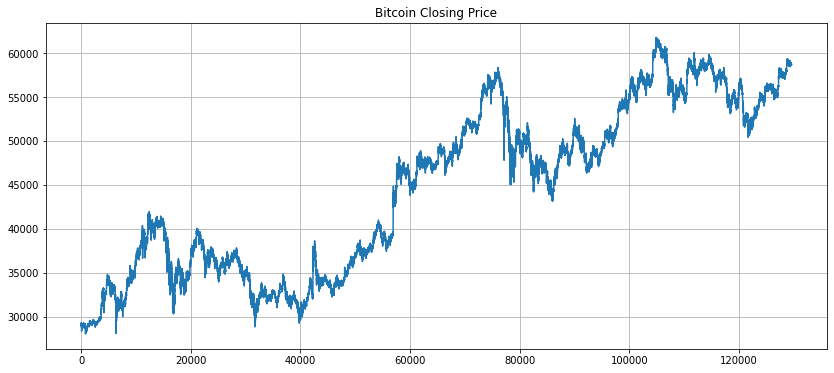

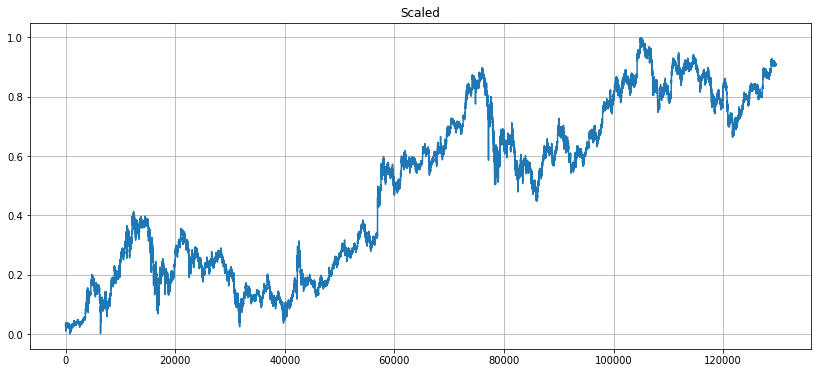

In [6]:
close_price = np.array(filtered['Close']).reshape(-1, 1)
plt.figure(figsize=(14, 6))
plt.title("Bitcoin Closing Price")
plt.grid()
plt.plot(close_price)

sc = MinMaxScaler()
close_priceSC = sc.fit_transform(close_price)
plt.figure(figsize=(14, 6))
plt.title("Scaled")
plt.grid()
plt.plot(close_priceSC)

X = []
y = []

for i in range(60, len(close_priceSC)):
    X.append(close_priceSC[i-60:i, 0])
    y.append(close_priceSC[i, 0])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)


Splitting train and test

In [7]:
# Separar Dados de Treino e Teste
limitTrain = int((len(X) * 0.98))

X_train = X[:limitTrain, :]
X_test = X[limitTrain:, :]

y_train = y[:limitTrain]
y_test = y[limitTrain:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

willPredictInDays = len(y_test) / 60 / 24
print("Previsão aproximada de {0:g} dias".format(round(willPredictInDays, 0)))


(126950, 60) (2591, 60) (126950,) (2591,)
Previsão aproximada de 2 dias


Plotting train and test data

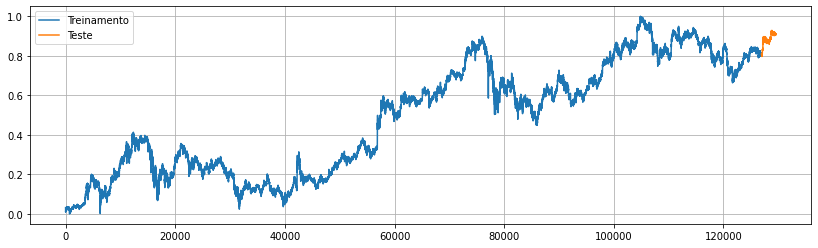

In [8]:
plt.figure(figsize=(14, 4))
plt.plot(range(limitTrain), y_train)
plt.plot(range(limitTrain, len(y)), y_test)
plt.legend(["Treinamento", "Teste"])
plt.grid()


Preparing X for LSTM

In [18]:
X_train = X_train.reshape(-1, 60, 1)
X_test = X_test.reshape(-1, 60, 1)
print(X_train.shape, X_test.shape)

print(np.argwhere(np.isnan(X_train)))



(126950, 60, 1) (2591, 60, 1)
[[ 23052     59      0]
 [ 23053     58      0]
 [ 23054     57      0]
 ...
 [126895      2      0]
 [126896      1      0]
 [126897      0      0]]


Train using LSTM 

In [10]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True,
              input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))

# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))

# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
regressor.fit(X_train, y_train, epochs=1, batch_size=500)


2022-04-21 18:45:02.899922: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (34)
2022-04-21 18:45:02.900009: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (4236b887cd70): /proc/driver/nvidia/version does not exist
2022-04-21 18:45:02.900411: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


195/254 [======================>.......] - ETA: 1:03 - loss: nan

KeyboardInterrupt: 

In [ ]:
y_pred = regressor.predict(X_test)
MSE = mean_absolute_error(y_test, y_pred)


In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(sc.inverse_transform(y_test.reshape(-1, 1)))
plt.plot(sc.inverse_transform(y_pred.reshape(-1, 1)))
plt.title("Comparison with MAE {0:0.10f}".format(MSE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")


This is clearly overfitting